# Perturbation-Based Saliency
This notebook develops and investigates the perturbation-based methods in the following paper:

*Greydanus et al., Visualizing and Understanding Atari Agents, 2017. arXiv.org*

## Initial setup

In [30]:
# ViZDoom setup
from vizdoom import *
import sys
sys.path.insert(0, "../python")
from helper import create_network, create_agent

# Numerical packages
import tensorflow as tf
import numpy as np
import math
import random
from skimage.transform import resize
from scipy.interpolate import interp2d

# Utils
from time import time
from copy import copy
import matplotlib.pyplot as plt
%matplotlib inline

# Display
from IPython.display import display, clear_output

# gif generation
import moviepy.editor as mpy
import imageio
import os

## Gaussian perturbation
First we will develop the method to blur a single image with a Gaussian centered on some pixel $(i,j)$:

$\phi(I_t, i, j) = I_t \odot (1 - M(i,j)) + A(I_t, \sigma_A) \odot M(i,j)$,

where $\phi$ is the perturbed image, $I_t$ is the original image, $A$ is the blurred image, and $M$ is the mask.

### Create mask: $M(i,j)$
The authors used a 2D Gaussian centered at $\mu = (i,j)$ with $\sigma^2 = 25$. Given that their implementation used 80 x 80 images, we can scale the variance accordingly to be $25/80=0.3125$ of the image dimension.

Note: We can actually create this more easily by simply taking the outer product of two 1D Gaussians center on $i$ and $j$, respectively. This is done for the Gaussian kernel below.

In [2]:
# Parameters
dim = 84 # image height/width
[mu_i, mu_j] = [55, 30] # center of 2D Gaussian
var = 0.3125 * dim # variance of 2D Gaussian

# Create mean vector μ
mu = np.array([[mu_i, mu_j]]).T # shape [2, 1]

# Create covariance matrix Σ
covar = np.diag(np.array([var, var]))
covar_det = var**2 # det(covar) = var**2
covar_inv = np.diag(np.array([1/var, 1/var])) # inv(covar)

# Create coordinate array x such that x[i,j] = [i, j]
x = np.zeros([dim, dim, 2])
x[:, :, 0] = np.arange(dim)
x[:, :, 1] = np.arange(dim)
x[:, :, 0] = x[:, :, 0].T
x = np.expand_dims(x, -1) # shape [dim, dim, 2, 1]

# Create 2D Gaussian mask
k = 1/(2*math.pi*covar_det)**0.5
M = k * np.exp(-0.5 * np.transpose((x - mu), [0, 1, 3, 2]) @ (covar_inv @ (x - mu)))
M /= np.max(M) # normalize
M = np.squeeze(M) # shape [dim, dim]

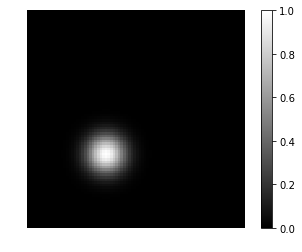

In [3]:
fig, ax = plt.subplots()
ax.axis("off")
im = ax.imshow(M, cmap='gray')
cbar = ax.figure.colorbar(im, ax=ax)

### Create blurred image from original: $A(I_t, \sigma_A)$

In [10]:
# Setup
tf.reset_default_graph()
agent_file = "./perturbation_saliency/ddqn_1.json"
config_file = "./perturbation_saliency/open_field_1.cfg"
results_dir = "./perturbation_saliency/dump/"
action_set = "basic_three"
num_actions = 20

# Create new game
game = DoomGame()
game.load_config(config_file)
game.init()

# Create new agent
agent = create_agent(agent_file,
                     game=game, 
                     params_file=None,
                     action_set=action_set,
                     output_directory=results_dir)

# Take few actions in new episode to fill agent state
agent.initialize_new_episode()
for i in range(num_actions):
    a = random.randint(0, 2)
    agent.make_action(agent.actions[a])
screen = game.get_state().screen_buffer
I = agent.state[0] # screen component of state
print(screen.shape)
print(I.shape)
game.close()

Mapping of agent states --> network states:
screen --> Tensor("main_network/screen:0", shape=(?, 4, 84, 84), dtype=float32)
[GameVariable.HEALTH] --> Tensor("main_network/health:0", shape=(?, 1), dtype=float32)
[GameVariable.VELOCITY_X, GameVariable.VELOCITY_Y] --> Tensor("main_network/velocity:0", shape=(?, 2), dtype=float32)
(225, 400)
(4, 84, 84)


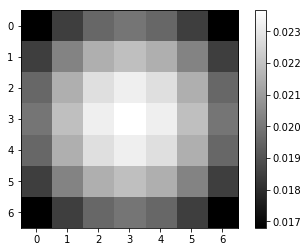

In [11]:
# Construct Gaussian kernel
var_A = 3 # variance
n = 7 # kernel dimension
t = np.linspace(-(n//2), n//2, n)
k_1d = (1/(2*math.pi*var)**0.5) * np.exp(-0.5 * t**2/var) # 1D kernel
k_2d = k_1d[:, np.newaxis] * k_1d[np.newaxis, :] # 2D kernel
k_1d /= np.sum(k_1d) # make sum = 1 to avoid adding energy to image
k_2d /= np.sum(k_2d)
im = plt.imshow(k_2d, cmap='gray')
bar = plt.colorbar(im)

Because the 2D Gaussian kernel can be decomposed into two 1D vectors, we can actually compute it using two separate 1D convolutions, first horizontally with the 1xn component, and then vertically with the mx1 component. For example, [see here](https://computergraphics.stackexchange.com/questions/39/how-is-gaussian-blur-implemented).

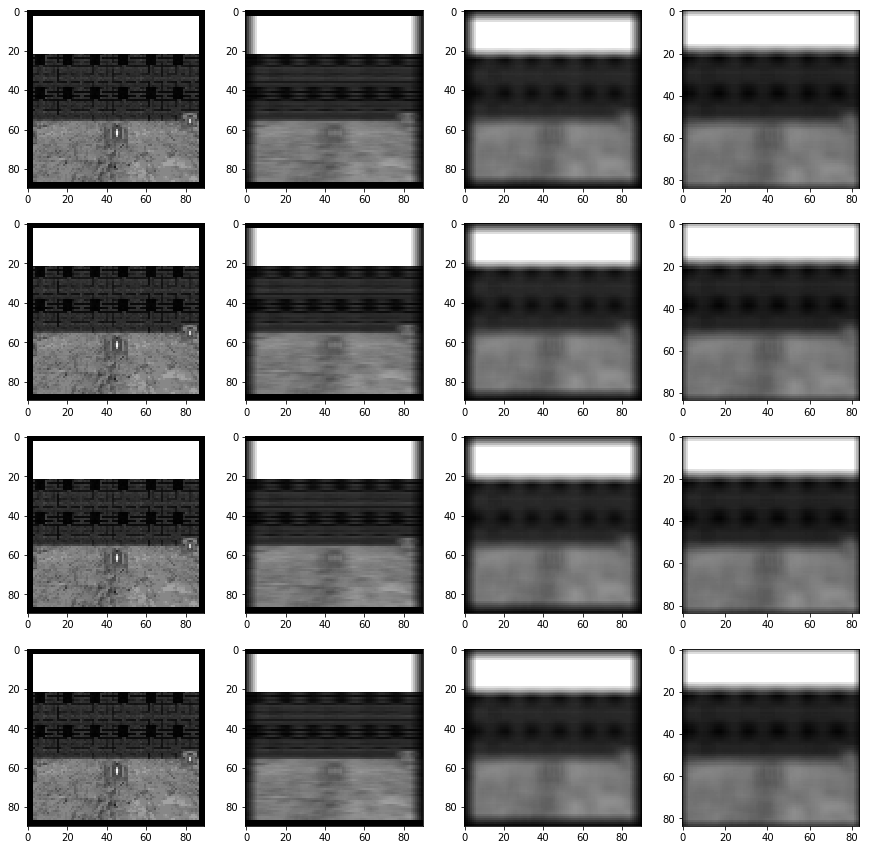

In [12]:
# Convolute the kernel with the original image
A = np.zeros(I.shape)
pad = n // 2
num_images = I.shape[0]
fig, ax = plt.subplots(num_images, 4, figsize=(15, 15))

for i in range(num_images):
    I_ = np.pad(I[i], pad, 'constant')
    shape_ = I_.shape
    ax[i, 0].imshow(I_, cmap='gray') # check padding
    I_ = I_.flatten()
    I_ = np.convolve(I_, k_1d, mode='same') # horizontal convolution
    I_ = I_.reshape(shape_) # reshape to 2D
    ax[i, 1].imshow(I_, cmap='gray') # check horizontal convolution
    I_ = I_.T.flatten() # transpose for vertical convolution 
    I_ = np.convolve(I_, k_1d, mode='same') # vertical convolution
    I_ = I_.reshape(shape_).T # reshape and transpose to original shape and order
    ax[i, 2].imshow(I_, cmap='gray') # check vertical convolution
    I_ = I_[pad:-pad, pad:-pad]
    ax[i, 3].imshow(I_, cmap='gray') # check boundary effects
    A[i] = I_

### Apply mask to blurred image: $A(I_t, \sigma_A) \odot M(i,j)$

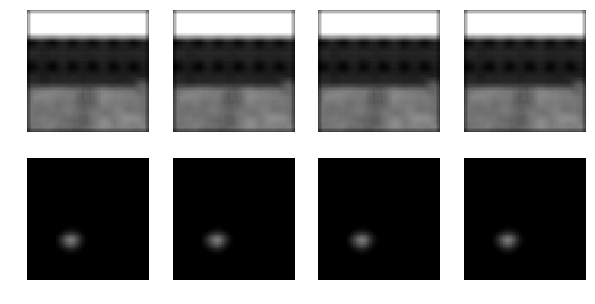

In [13]:
A_mask = np.zeros(A.shape)

fig, ax = plt.subplots(2, 4, figsize=(10, 5))
for i in range(4):
    ax[0, i].axis("off")
    ax[0, i].imshow(A[i], cmap='gray')
    A_mask[i] = A[i] * M
    ax[1, i].axis('off')
    ax[1, i].imshow(A_mask[i], cmap='gray', vmin=np.min(A[i]), vmax=np.max(A[i]))

### Add components: $\phi(I_t, i, j) = I_t \odot (1 - M(i,j)) + A(I_t, \sigma_A) \odot M(i,j)$

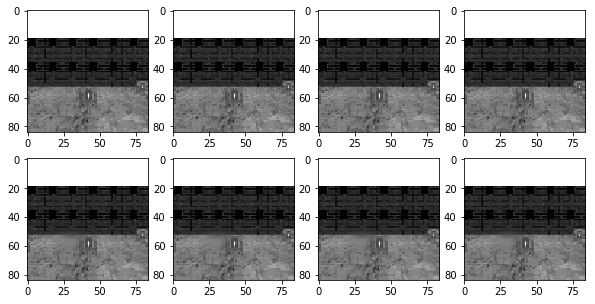

In [14]:
phi = I * (1.0 - M) + A_mask

fig, ax = plt.subplots(2, 4, figsize=(10, 5))
for i in range(4):
    ax[0, i].imshow(I[i], cmap='gray')
    ax[1, i].imshow(phi[i], cmap='gray')

## Saliency at single point
Now that we can selectively perturb an image around a region centered at $(i,j)$, let's see how that affects the agent, in particular the Q-function (since these will be DQN-based agents). Adapting the equation from the paper, we can define saliency at time $t$ for location $(i,j)$ in regards to the Q-function as:

$S_Q(t,i,j) = \frac{1}{2} \left \| Q(I_{1:t}) - Q(I'_{1:t}) \right \|^2$,

where $I'_{1:t} = [I_1, I_2, ..., I_{t-1}, \phi(I_t, i, j)]$. That is, only the last image is perturbed in the sequence that compromises input to the network.

### Define function to blur images as above

In [15]:
def phi(I, i, j, var_M=None, var_A=3, k_len=5):
    """Applies regional blurring centered at point (i,j) to image I"""
    
    # Check shape
    if I.shape[0] != I.shape[1]:
        raise ValueError("Image must be square.")
    
    # Mask parameters
    dim = I.shape[0] # image height/width
    [mu_i, mu_j] = [i, j] # center of 2D Gaussian
    var = 0.3125 * dim # variance of 2D Gaussian

    # Create mean vector μ
    mu = np.array([[mu_i, mu_j]]).T # shape [2, 1]

    # Create covariance matrix Σ
    covar = np.diag(np.array([var, var]))
    covar_det = var**2 # det(covar) = var**2
    covar_inv = np.diag(np.array([1/var, 1/var])) # inv(covar)

    # Create coordinate array x such that x[i,j] = [i, j]
    x = np.zeros([dim, dim, 2])
    x[:, :, 0] = np.arange(dim)
    x[:, :, 1] = np.arange(dim)
    x[:, :, 0] = x[:, :, 0].T
    x = np.expand_dims(x, -1) # shape [dim, dim, 2, 1]

    # Create 2D Gaussian mask
    k = 1/(2*math.pi*covar_det)**0.5
    M = k * np.exp(-0.5 * np.transpose((x - mu), [0, 1, 3, 2]) @ (covar_inv @ (x - mu)))
    M /= np.max(M) # normalize
    M = np.squeeze(M) # shape [dim, dim]
    
    # Construct Gaussian kernel with variance [var_A] and shape [k_len, k_len]
    n = k_len # kernel dimension
    t = np.linspace(-(n//2), n//2, n)
    k_1d = (1/(2*math.pi*var)**0.5) * np.exp(-0.5 * t**2/var) # 1D kernel
    k_1d /= np.sum(k_1d) # make sum = 1 to avoid adding energy to image
    
    # Convolute the kernel with the original image
    pad = n // 2
    I_ = np.pad(I, pad, 'constant')
    shape_ = I_.shape
    I_ = I_.flatten()
    I_ = np.convolve(I_, k_1d, mode='same') # horizontal convolution
    I_ = I_.reshape(shape_) # reshape to 2D
    I_ = I_.T.flatten() # transpose for vertical convolution 
    I_ = np.convolve(I_, k_1d, mode='same') # vertical convolution
    I_ = I_.reshape(shape_).T # reshape and transpose to original shape and order
    A = I_[pad:-pad, pad:-pad] # remove padding
    
    # Apply mask to components
    return I * (1.0 - M) + A * M

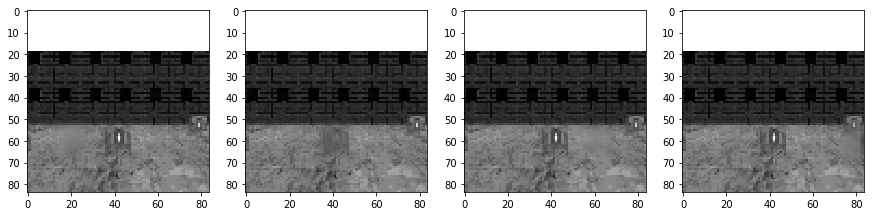

In [16]:
# Quick test for phi function
ix = [60] * 4
jx = [20*x for x in range(1, 5)]
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for k, [i, j] in enumerate(zip(ix, jx)):
    ax[k].imshow(phi(I[-1], i, j), cmap='gray')

### Test saliency at single time step
Find saliency at every mth pixel with verbose printout.

In [17]:
# Setup
m = 4 # stride over image
S = np.zeros([I[-1].shape[0] // m, I[-1].shape[1] // m])

# Find Q(I_1:t)
Q = agent.get_layer_output("Q", state=[I, agent.state[1]])[0]

# Iterate over image with stride [m, m]
for i in range(0, I[-1].shape[0], m):
    for j in range(0, I[-1].shape[1], m):
        # Find Q(I`_1:t)
        I_p = copy(I)
        I_p[-1] = phi(I[-1], i, j)
        Q_p = agent.get_layer_output("Q", state=[I_p, agent.state[1]])[0]
        
        # Saliency = MSE (proportional to directional gradient)
        S[i//m, j//m] = 0.5 * np.sum((Q_p - Q)**2)**0.5
        
        # Print results
        print("Perturbation at (%d, %d):" % (i, j))
        print("Q:", Q)
        print("Q`:", Q_p)
        print("S:", S[i//m, j//m])
        print()

Perturbation at (0, 0):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58286  -67.341194 141.82452 ]]
S: 1.7481138973067626e-05

Perturbation at (0, 4):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58287 -67.34116 141.8245 ]]
S: 3.191604715477278e-05

Perturbation at (0, 8):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58286 -67.34119 141.82454]]
S: 1.7059844799040144e-05

Perturbation at (0, 12):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58288 -67.34121 141.8246 ]]
S: 3.1687255336448955e-05

Perturbation at (0, 16):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58291 -67.34121 141.82458]]
S: 2.442598051999225e-05

Perturbation at (0, 20):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58291  -67.341225 141.82457 ]]
S: 2.0542773464715972e-05

Perturbation at (0, 24):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.5829  -67.34124 141.82455]]
S: 2.089395742436089e-05

Perturbation at (0, 28):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.5829   -67.341225 141.82452 ]]
S: 1.427

Perturbation at (16, 44):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58266 -67.34112 141.82465]]
S: 0.00013637209267974455

Perturbation at (16, 48):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58271 -67.34121 141.82465]]
S: 0.00010605956096235538

Perturbation at (16, 52):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58275 -67.34128 141.82455]]
S: 8.225959263934259e-05

Perturbation at (16, 56):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58276 -67.34123 141.82446]]
S: 7.676930159568065e-05

Perturbation at (16, 60):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58276 -67.34109 141.82443]]
S: 0.00010164575648860343

Perturbation at (16, 64):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58284 -67.34104 141.82451]]
S: 8.580949309693903e-05

Perturbation at (16, 68):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58288  -67.341156 141.82466 ]]
S: 6.563053334840871e-05

Perturbation at (16, 72):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58286 -67.34127 141.82477]]
S: 0

Perturbation at (32, 60):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58291 -67.34119 141.82451]]
S: 1.8688123647942946e-05

Perturbation at (32, 64):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58291 -67.34116 141.82446]]
S: 4.332663227691859e-05

Perturbation at (32, 68):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58289 -67.34118 141.82446]]
S: 3.982660869182797e-05

Perturbation at (32, 72):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58287  -67.341194 141.82452 ]]
S: 1.4273290202232137e-05

Perturbation at (32, 76):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.582886 -67.34121  141.82454 ]]
S: 5.3947966093944364e-06

Perturbation at (32, 80):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58288 -67.34121 141.82457]]
S: 1.7481138973067626e-05

Perturbation at (36, 0):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58286 -67.34118 141.82454]]
S: 1.9073486328125e-05

Perturbation at (36, 4):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.582855 -67.34117  141.82455 ]]
S

Perturbation at (48, 68):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58284 -67.34127 141.82458]]
S: 4.914893618288088e-05

Perturbation at (48, 72):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.582855 -67.341255 141.82455 ]]
S: 3.369049402743472e-05

Perturbation at (48, 76):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58287 -67.34123 141.82457]]
S: 2.442598051999225e-05

Perturbation at (48, 80):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58286 -67.34121 141.82454]]
S: 1.5728399755926745e-05

Perturbation at (52, 0):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58295 -67.3412  141.82448]]
S: 4.055078816503391e-05

Perturbation at (52, 4):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.582954 -67.34118  141.8245  ]]
S: 3.982660869182797e-05

Perturbation at (52, 8):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.582924 -67.341125 141.82454 ]]
S: 4.1085546929431944e-05

Perturbation at (52, 12):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.582886 -67.341095 141.82455 ]]

Perturbation at (68, 0):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58287 -67.34118 141.8246 ]]
S: 3.454355292563407e-05

Perturbation at (68, 4):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58289 -67.34118 141.8246 ]]
S: 3.259278772475254e-05

Perturbation at (68, 8):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58292 -67.34118 141.8246 ]]
S: 3.454355292563407e-05

Perturbation at (68, 12):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58291 -67.34118 141.82458]]
S: 2.6702880859375e-05

Perturbation at (68, 16):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.582886 -67.341156 141.82462 ]]
S: 4.464988674438334e-05

Perturbation at (68, 20):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58289  -67.341194 141.8246  ]]
S: 3.0755072587198445e-05

Perturbation at (68, 24):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.582886 -67.34119  141.82452 ]]
S: 1.1444091796875e-05

Perturbation at (68, 28):
Q: [[-90.58289 -67.3412  141.82454]]
Q`: [[-90.58289 -67.34117 141.82452]]
S: 1.70

### Upsampling techniques
Both look good. I guess I'll use `interp2d` because the boundary looks a little nicer...

#### Technique 1: 2D interpolation

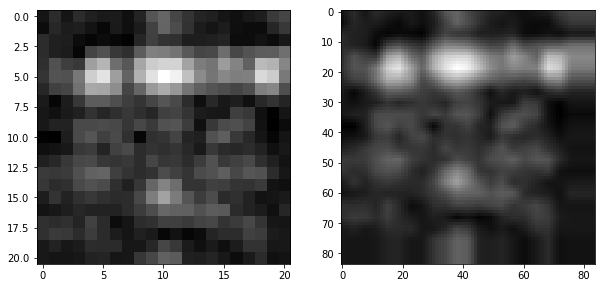

In [18]:
x = np.arange(S.shape[1])
y = np.arange(S.shape[0])
f = interp2d(x, y, S, kind='linear')

x_new = np.linspace(0, (S.shape[1] + S.shape[1]%m), I[0].shape[1])
y_new = np.linspace(0, (S.shape[0] + S.shape[0]%m), I[0].shape[0])
S_new = f(x_new, y_new)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(S, cmap='gray')
ax[1].imshow(S_new, cmap='gray')

#### Technique 2: resize from skimage

/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


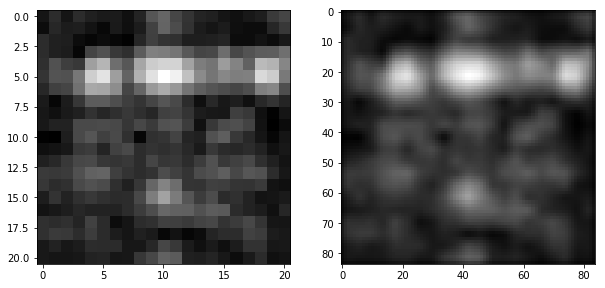

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(S, cmap='gray')
ax[1].imshow(resize(S, [84, 84]), cmap='gray')

### Visualize saliency
Let's visualize the saliency by adding it back into the original image. Using the original RGB screen buffer is a little tricky since, at least in this network, the preprocessing steps for the input include both downsizing and converting to grayscale, making it difficult to create an RGB image that is downsized alone. For simplicity, let's just expand the grayscale into an RGB image (i.e. copy pixel values onto each of three channels), then add the saliency to only one channel.

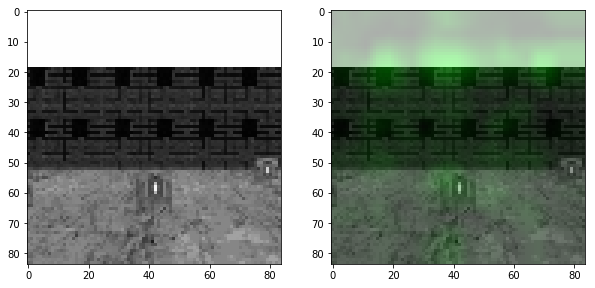

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

I_RGB = np.resize(I[-1], [3] + list(I[-1].shape))
ax[0].imshow(I_RGB.transpose([1, 2, 0]))

b = 0.5 # max amount to add to G channel
I_RGB[1] += S_new / np.max(S_new) * b
if (I_RGB > 1.0).any():
    I_RGB /= np.max(I_RGB)
ax[1].imshow(I_RGB.transpose([1, 2, 0]))

## Saliency videos
We will follow a similar procedure as above, but now do it for each image in the episode to generate a saliency video (gif). Note: code adapted from `visualizing_screens.ipynb`.

### Generate saliency maps
First, we must generate and save a saliency map for each image in the episode. Two important (slightly annoying) details to note:
- The agent state is a list compromised of two parts: the previous n images (`agent.state[0]`) and the current game variables (`agent.state[1]`).
- The network file to which the agent file points (i.e. `network_args["name"]` in `agent_file`) must be located in the `networks/` directory and, if parameters are being loaded, must match the network file used to generate that graph. In other words, if parameters are being reused, the computational graphs must be the same.

Additionally, we will have to modify our code slightly to generate saliency maps. Because we want the flexibility to generate maps for networks that use either grayscale or RGB images, we will allow our `saliency_map` function to accept either type of image (but still only a single image). This will lead to a rather inefficient implementation of transforming an RGB image (calling `phi` three times), but we can eat the cost for now and deal with it later if the inefficiency is causing real problems.

In [35]:
def saliency_map(I, num_channels=1, m=4):
    """
    Generates saliency map S(t) = 0.5||Q(I) - Q(I`)||^2
    
    Args:
    - I: sequence of input images I_1:I_t that comprise state fed into network. Must be of
         shape [num_channels * t, height, width].
    - m: stride over image, calculating saliency at every mth pixel
    """
    # Get image shape and type
    if I.ndim ==2:
        I = np.expand_dims(I, axis=0)
        num_channels = 1
    S = np.zeros([I.shape[1] // m, I.shape[2] // m])

    # Find Q(I_1:t)
    Q = agent.get_layer_output("Q", state=[I, agent.state[1]])[0]

    # Iterate over image with stride [m, m]
    for i in range(0, I.shape[1], m):
        for j in range(0, I.shape[2], m):
            # Find Q(I`_1:t)
            I_p = copy(I)
            for k in range(num_channels):
                I_p[-k] = phi(I[-k], i, j)
            Q_p = agent.get_layer_output("Q", state=[I_p, agent.state[1]])[0]

            # Saliency = MSE (proportional to directional gradient)
            S[i//m, j//m] = 0.5 * np.sum((Q_p - Q)**2)**0.5

    # Upsample to size of images in agent state (I_1:I_t)
    x = np.arange(S.shape[1])
    y = np.arange(S.shape[0])
    f = interp2d(x, y, S, kind='linear') # current mapping function
    x_us = np.linspace(0, (S.shape[1] + S.shape[1]%m), I.shape[2])
    y_us = np.linspace(0, (S.shape[0] + S.shape[0]%m), I.shape[1])
    S_us = f(x_us, y_us) # map to new dimensions
    
    return S_us

In [41]:
# Setup
tf.reset_default_graph()
agent_file = "./perturbation_saliency/ddqn_2.json"
params_file = "../experiments/open_field/trial_44/train_data/net_data/main_net/params/train_model-175"
config_file = "./perturbation_saliency/open_field_2.cfg"
results_dir = "./perturbation_saliency/results/"
action_set = None
b = 0.5 # scales brightness reduction; max amount to add to green channel

# Create new game
game = DoomGame()
game.load_config(config_file)
game.init()

# Create new agent
agent = create_agent(agent_file,
                     game=game, 
                     params_file=params_file,
                     action_set=action_set,
                     output_directory=results_dir)

INFO:tensorflow:Restoring parameters from ../experiments/open_field/trial_44/train_data/net_data/main_net/params/train_model-175
Restoring params from ../experiments/open_field/trial_44/train_data/net_data/main_net/params/train_model-175
Mapping of agent states --> network states:
screen --> Tensor("main_network/screen:0", shape=(?, 3, 84, 84), dtype=float32)
[GameVariable.HEALTH] --> Tensor("main_network/health:0", shape=(?, 1), dtype=float32)
[GameVariable.VELOCITY_X, GameVariable.VELOCITY_Y] --> Tensor("main_network/velocity:0", shape=(?, 2), dtype=float32)


In [42]:
# Play one episode
I_S = []
agent.initialize_new_episode()
while not game.is_episode_finished():
    # Print progress
    clear_output(wait=True)
    [t, t_max] = game.get_episode_time(), game.get_episode_timeout()
    display("Creating saliency map %d of max %d" % (t//agent.frame_repeat, t_max//agent.frame_repeat))
    
    # Update current state
    current_screen = game.get_state().screen_buffer
    agent.update_state(current_screen)
    
    # Create saliency map of current state
    I = agent.state[0] # [I_1, ..., I_t]
    S = saliency_map(I, num_channels=agent.channels, m=4) # S(t)
    if I.ndim == 2:
        # Expand dims of single grayscale image
        I_S_i = np.resize(I, [agent.channels] + list(I.shape))
    else:
        # Get last grayscale or RGB image
        I_S_i = I[-agent.channels:]
    I_S_i[1] += S / np.max(S) * b # add saliency to green channel
    if (I_S_i > 1.0).any(): # reduce brightness if necessary to keep green dynamic range
        I_S_i /= np.max(I_S_i)
    I_S.append(I_S_i)

    # Make action based on learning algorithm
    r = agent.make_action()
    agent.track_action()

game.close()

'Creating saliency map 254 of max 250'

### Create gif from images

In [43]:
# Adapted from python/Toolbox.py
def make_gif(images, filepath, duration=None, fps=35, channels=1, color_format='RGB'):
    def make_frame(t):
        # Grab image, accounting for rounding error
        idx = int(round(t * fps_))
        try: 
            img = images[idx]
        except IndexError: # out of bounds
            img = images[-1]

        # Convert to [H, W, C] if not already
        if img.shape[0] == channels:
            img = np.transpose(img, [1, 2, 0])

        # If color, ensure channels in RGB order;
        # if grayscale, trim to [H, W]
        if channels == 4:
            r = color_format.find("R")
            g = color_format.find("G")
            b = color_format.find("B")
            img = img[..., [r, g, b, 3]]
        elif channels == 3:
            r = color_format.find("R")
            g = color_format.find("G")
            b = color_format.find("B")
            img = img[..., [r, g, b]]
        elif channels == 1:
            img = np.squeeze(img)

        # Rescale to [0, 255] if necessary
        if np.max(img) <= 1.0:
            img = 255.0 * img

        return img

    # Determine duration and/or frames per second
    if duration is not None:
        # Make clip of specified duration (not guaranteed to include
        # all images)
        duration_ = duration
        fps_ = len(images) / duration_
    else:
        # Make clip of entire sequence to match frame rate
        duration_ = len(images) / fps
        fps_ = fps

    # Create .gif file
    clip = mpy.VideoClip(make_frame, duration=duration_)
    if not filepath.endswith(".gif"):
        filepath += ".gif"
    clip.write_gif(filepath, fps=fps_)

In [44]:
gif_filepath= "./perturbation_saliency/results/saliency_map"
I_S = np.asarray(I_S)
make_gif(I_S, gif_filepath, channels=3, fps=35/agent.frame_repeat)


[MoviePy] Building file ./perturbation_saliency/results/saliency_map.gif with imageio


100%|██████████| 251/251 [00:02<00:00, 109.96it/s]


(250, 3, 84, 84)


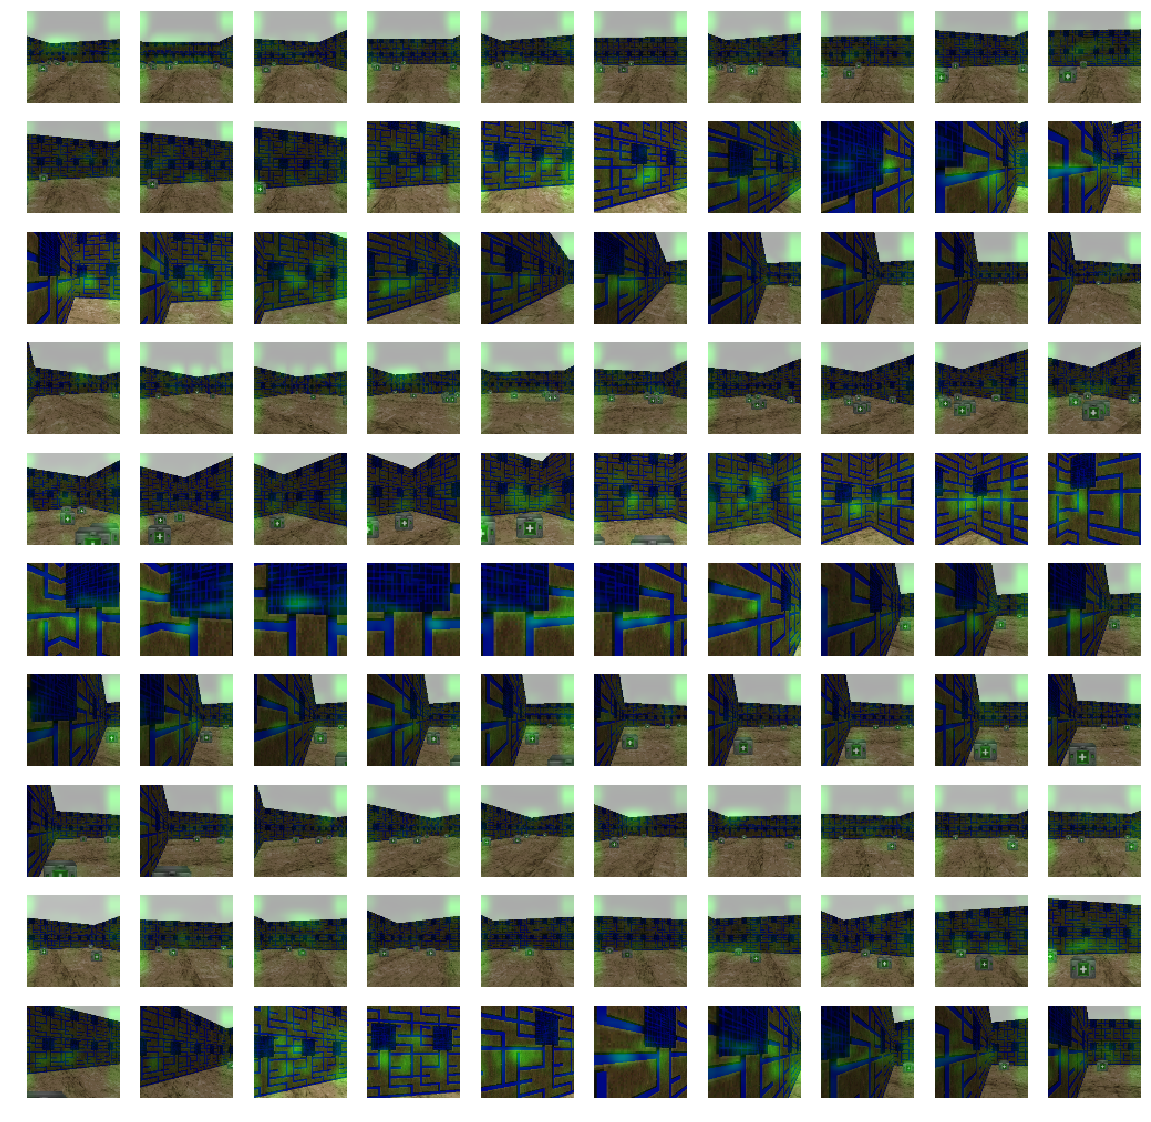

In [45]:
# Plot 100 images during time [start, start + 100]
print(I_S.shape)
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
start = -150
for i in range(10):
    for j in range(10):
        t = start + (10*i + j)
        ax[i, j].axis('off')
        ax[i, j].imshow(I_S[t].transpose([1, 2, 0]))

### Create gifs from multiple episodes
Work in progress...

In [ ]:
# Setup
num_gifs = 1
results_dir = "./perturbation_saliency/dump/" # output for agent variables
rows = 1
cols = 1
output_dir = "/home/james/Desktop/screens/" # temp folder to store images to make gif

filenames = ["saliency_map-%d.gif" % i for i in range(1, num_gifs+1)]
gifs = []
for i, f in enumerate(filenames):
    img = Image.open(results_dir + f)
    imgs = []
    j = 1
    while img:
        imgs.append(img.convert('RGB'))
        try:
            img.seek(j)
            j += 1
        except EOFError:
            break
    gifs.append(imgs)


fig, axes = plt.subplots(rows, cols)
gifs_finished = np.zeros(num_gifs, dtype=np.bool)
for i in range(axes.size):
    axes[i//cols][i%cols].axis('off')

i = 0
while not gifs_finished.all():
    for j, gif in enumerate(gifs):
        ax = axes[j//cols][j%cols] 
        try:
            ax.imshow(gif[i])
        except IndexError:
            ax.imshow(gif[-1])
            gifs_finished[j] = True
    plt.savefig(output_dir + 'image-%d.png' % i)
    i += 1